In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
from sklearn.metrics import matthews_corrcoef
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_wine, load_iris
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import csv
import os
import time
import warnings

In [9]:
datasets = [
    ("Iris", lambda: load_iris()),
    ("WBDC (Breast Cancer Wisconsin Diagnostic)", lambda: fetch_openml(data_id=1510, as_frame=False)),
    ("Spambase", lambda: fetch_openml(name="spambase", version=1, as_frame=False)),
    ("Heart", lambda: fetch_openml(data_id=533, as_frame=False)),
    ("Glass", lambda: fetch_openml(name="glass", version=2, as_frame=False)),
    ("WBC (Breast Cancer Wisconsin Original)", lambda: fetch_openml(data_id=15, as_frame=False)),
    ("Ionosphere", lambda: fetch_openml(name="ionosphere", version=1, as_frame=False)),
    ("Arrhythmia", lambda: fetch_openml(name="arrhythmia", version=1, as_frame=False)),
    ("Multiple Features", lambda: fetch_openml(name="mfeat-factors", version=1, as_frame=False)),
    ("Australian", lambda: fetch_openml(name="australian", as_frame=False)),
    #("German Number (Credit Dataset)", lambda: fetch_openml(name="credit-g", version=1, as_frame=False)),
    ("DNA", lambda: fetch_openml(name="dna", version=1, as_frame=False)),
    ("Wine", lambda: load_wine()),
    ("Vehicle", lambda: fetch_openml(name="vehicle", version=2, as_frame=False)),
    ("Waveform", lambda: fetch_openml(name="waveform-5000", version=2, as_frame=False)),
    #("Zoo", lambda: fetch_openml(name="zoo", version=2, as_frame=False)),
    ("Hillvalley", lambda: fetch_openml(name="hill-valley", version=2, as_frame=False)),
    ("Sonar", lambda: fetch_openml(name="sonar", version=1, as_frame=False)),
    #("Musk 1", lambda: fetch_openml(name="musk", version=1, as_frame=False))
]


In [3]:
from sklearn.metrics import make_scorer, roc_auc_score
scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [35]:
def Baseline(estimator, fold=10, X=None, y=None, scoring='accuracy', param_grid=None, dataset_name="dataset", output_dir="results"):
    """
    Baseline evaluation function for a given estimator with optional hyperparameter tuning.
    Saves the results to a CSV file and returns a dictionary of evaluation metrics.
    """
    scoring_functions = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'matthews_corrcoef': make_scorer(matthews_corrcoef)
    }

    if scoring not in scoring_functions:
        raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")

    # Create preprocessing steps for all features
    preprocessor = ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), X.columns)]
    )

    # Create a pipeline with the preprocessor and the estimator
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', estimator)])

    # Perform hyperparameter tuning with GridSearchCV if param_grid is provided
    if param_grid:
        cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring_functions[scoring], error_score='raise')
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X, y)
        best_estimator = pipeline
        best_params = {}

    # Perform cross-validation with the best estimator
    scores = cross_val_score(best_estimator, X, y, cv=fold, scoring=scoring_functions[scoring])

    # Calculate AUC and standard deviation
    auc_score = scores.mean()
    auc_std = scores.std()

    # Return results as a dictionary
    return {
        'Framework': type(estimator).__name__,
        'Dataset': dataset_name,
        'AUC': auc_score,
        'AUC_STD': auc_std,
        'Best_Params': best_params
    }



In [36]:
# Parameters for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

results = []
output_dir = "results"

# Single CSV file to store all results
results_file = os.path.join(output_dir, "baseline_results_with_timings.csv")
os.makedirs(output_dir, exist_ok=True)

# Ensure the CSV file starts with headers
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dataset", "Framework", "AUC", "AUC_STD", "Best_Params", "Time_Taken"])

# Iterate over datasets
for dataset_name, loader in datasets:
    try:
        # Load data
        data = loader()
        X, y = (data.data, data.target) if hasattr(data, 'data') else (data['data'], data['target'])

        # Convert X to DataFrame for compatibility
        X = pd.DataFrame(X)

        # Record dataset evaluation start time
        dataset_start_time = time.time()

        # Run baseline evaluation
        result = Baseline(
            estimator=KNeighborsClassifier(),
            fold=10,
            X=X,
            y=y,
            scoring='accuracy',
            param_grid=param_grid,
            dataset_name=dataset_name,
            output_dir=output_dir
        )

        # Add time taken for the dataset
        result['Time_Taken'] = time.time() - dataset_start_time

        # Append results
        results.append(result)

        # Write results directly to the single CSV file
        with open(results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                result['Dataset'],
                result['Framework'],
                result['AUC'],
                result['AUC_STD'],
                result['Best_Params'],
                result['Time_Taken']
            ])

    except Exception as e:
        print(f"Error with dataset {dataset_name}: {e}")

# Print all results
for res in results:
    print(res)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


{'Framework': 'KNeighborsClassifier', 'Dataset': 'Iris', 'AUC': 0.8533333333333335, 'AUC_STD': 0.07180219742846006, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}, 'Time_Taken': 0.8872973918914795}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'WBDC (Breast Cancer Wisconsin Diagnostic)', 'AUC': 0.6854323308270677, 'AUC_STD': 0.04093269008836167, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}, 'Time_Taken': 3.652597665786743}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'Spambase', 'AUC': 0.7989625577666699, 'AUC_STD': 0.024622408860984428, 'Best_Params': {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}, 'Time_Taken': 27.089203119277954}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'Heart', 'AUC': 0.8191883116883115, 'AUC_STD': 0.045507263028688995, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}, 'Time_Taken': 1.015531063079834}
{'Framework': 'KNeighborsClassif

In [4]:
class SAGAFS_GA(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator, cv, scoring='accuracy', population_size=20, generations=10, mutation_rate=0.1, crossover_rate=0.5, param_grid=None):
        if not hasattr(estimator, 'fit'):
            raise ValueError("Estimator must have a 'fit' method.")
        if not hasattr(cv, 'split'):
            raise ValueError("cv must be a cross-validation splitter (e.g., StratifiedKFold).")
        if scoring not in ['accuracy', 'matthews_corrcoef', 'f1_score']:
            raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")
        if param_grid is None:
            raise ValueError("A parameter grid (param_grid) must be provided for hyperparameter tuning.")

        self.estimator = estimator
        self.cv = cv
        self.scoring = scoring
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.param_grid = param_grid
        self.best_individual = None
        self.best_scores_per_gen = []  # Initialize the tracking list for best scores

    def save_generation_results(self, generation, output_dir, avg_fitness, best_fitness, best_individual):
      """
      Saves results of each generation to a CSV file.
      """
      os.makedirs(output_dir, exist_ok=True)
      generation_file = os.path.join(output_dir, "generation_results.csv")

      # Check if the file exists to add headers only once
      file_exists = os.path.isfile(generation_file)
      with open(generation_file, mode='a', newline='') as file:
          writer = csv.writer(file)

          # Write header only if the file doesn't exist
          if not file_exists:
              writer.writerow(["Generation", "Average_Fitness", "Best_Fitness", "Best_Individual"])

          # Write generation results
          writer.writerow([generation, avg_fitness, best_fitness, list(best_individual)])

    def fit(self, X, y, dataset_name="dataset", output_dir="results"):
        # Handle target variable (y)
        if isinstance(y, pd.Series) or isinstance(y, np.ndarray):
            if y.dtype == object or isinstance(y[0], str):
                le = LabelEncoder()
                y = le.fit_transform(y)
        else:
            raise ValueError("Target variable (y) must be a pandas Series or a NumPy array.")

        # Handle input features (X)
        if isinstance(X, pd.DataFrame):
            numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
            categorical_features = X.select_dtypes(include=["object", "category"]).columns

            numeric_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler())
            ])
            categorical_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ])

            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", numeric_transformer, numeric_features),
                    ("cat", categorical_transformer, categorical_features)
                ]
            )

            X = preprocessor.fit_transform(X)
        else:
            try:
                X = np.asarray(X, dtype=float)
            except ValueError:
                raise ValueError("Input features X contain unsupported data types. Ensure X is numeric or a pandas DataFrame.")

        n_features = X.shape[1]
        start_time = time.time()

        # Initialize population: binary vectors for feature selection
        population = [np.random.randint(2, size=n_features) for _ in range(self.population_size)]

        for generation in range(1, self.generations + 1):
            fitness_scores = [self.fitness_function(X, y, individual) for individual in population]

            # Calculate average and best fitness for the generation
            avg_fitness = np.mean(fitness_scores)
            best_fitness = max(fitness_scores)
            best_individual = population[np.argmax(fitness_scores)]

            # Save results for the current generation
            self.save_generation_results(generation, output_dir, avg_fitness, best_fitness, best_individual)

            # Store the best fitness score of the current generation
            self.best_scores_per_gen.append(best_fitness)
            self.best_individual = best_individual

            # Perform crossover and mutation to create the next generation
            population = self.evolve_population(population)

        # Perform Grid Search for the selected features
        selected_features = np.where(self.best_individual == 1)[0]
        if len(selected_features) == 0:
            raise ValueError("No features were selected. Please adjust your parameters.")
        X_selected = X[:, selected_features]
        grid_search = GridSearchCV(self.estimator, param_grid=self.param_grid, cv=self.cv, scoring=self.scoring, error_score="raise")
        grid_search.fit(X_selected, y)

        # Extract the best results
        auc_score = grid_search.best_score_
        auc_std = np.std(cross_val_score(grid_search.best_estimator_, X_selected, y, cv=self.cv, scoring=self.scoring))
        best_params = grid_search.best_params_
        time_taken = time.time() - start_time

        # Save results
        self.save_results(dataset_name, "SAGAFS_GA", output_dir, auc_score, auc_std, best_params, time_taken)


    def fitness_function(self, X, y, feature_subset):
        selected_features = np.where(feature_subset == 1)[0]
        if len(selected_features) == 0:
            return 0
        X_selected = X[:, selected_features]
        scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
        return np.mean(scores)

    def preprocess_dataset(self, X, y):
        # Handle missing values in features
        imputer = SimpleImputer(strategy='mean')  # Use 'median' or 'most_frequent' as needed
        X = imputer.fit_transform(X)

        # Encode target variable if it's not numeric
        if isinstance(y[0], str) or not np.issubdtype(y.dtype, np.number):
            le = LabelEncoder()
            y = le.fit_transform(y)

        return X, y

    def evolve_population(self, population):
        # Update mutation and crossover rates dynamically
        self.update_rates()

        crossover = self.Crossover(self.crossover_rate)
        mutation = self.Mutation(self.mutation_rate)

        new_population = []
        while len(new_population) < self.population_size:
            # Randomly select two parents
            parents = random.sample(population, 2)
            # Apply crossover
            child1, child2 = crossover.apply(parents[0], parents[1])
            # Apply mutation
            child1 = mutation.apply(child1)
            child2 = mutation.apply(child2)
            # Add children to the new population
            new_population.append(child1)
            new_population.append(child2)

        return new_population[:self.population_size]

    def update_rates(self):
        """
        Dynamically adapt mutation and crossover rates based on progress.
        """
        # Use generation progress (e.g., linear annealing)
        progress = len(self.best_scores_per_gen) / self.generations  # Current generation progress ratio

        # Decrease mutation rate as generations progress
        self.mutation_rate = max(0.01, 0.1 * (1 - progress))  # Example: starts at 0.1, decreases to 0.01

        # Adjust crossover rate: high at start, lower at end
        self.crossover_rate = 0.5 + (0.3 * progress)  # Example: starts at 0.5, increases to 0.8


    def crossover(self, parent1, parent2):
        point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:point], parent2[point:]))
        child2 = np.concatenate((parent2[:point], parent1[point:]))
        return child1, child2

    def mutate(self, individual):
        if np.random.rand() < self.mutation_rate:
            index = np.random.randint(len(individual))
            individual[index] = 1 - individual[index]
        return individual

    def save_results(self, dataset_name, framework, output_dir, auc_score, auc_std, best_params, time_taken):
        os.makedirs(output_dir, exist_ok=True)
        summary_file = os.path.join(output_dir, "model_performance_summary.csv")

        # Append results to CSV
        file_exists = os.path.isfile(summary_file)
        with open(summary_file, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Write header only if the file doesn't exist
            if not file_exists:
                writer.writerow(["Dataset", "Framework", "AUC", "AUC_STD", "Best_Params", "Time_Taken"])

            # Write results
            writer.writerow([dataset_name, framework, auc_score, auc_std, best_params, time_taken])

    def plot_heatmap(self, feature_scores, feature_names):
        if len(feature_scores) != len(feature_names):
            raise ValueError("Feature scores and feature names must have the same length.")

        feature_scores_reshaped = np.array(feature_scores).reshape(1, -1)
        plt.figure(figsize=(10, 1))
        sns.heatmap(feature_scores_reshaped, annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=["Score"])
        plt.title("Feature Importance Heatmap")
        plt.show()


    def plot_fitness_over_generations(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.generations + 1), self.best_scores_per_gen, marker='o', color='b')
        plt.title("Fitness Score Evolution Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Score")
        plt.grid(True)
        plt.show()

    # Child class for crossover
    class Crossover:
        def __init__(self, crossover_rate):
            self.crossover_rate = crossover_rate

        def apply(self, parent1, parent2):
            """
            Crossover implementation based on the provided diagram.
            """
            n_features = len(parent1)
            o1 = []  # Offspring 1
            o2 = []  # Offspring 2

            # Step (a): Add common feature indices (features that both parents share)
            common_features = np.where((parent1 == parent2) & (parent1 == 1))[0]
            o1.extend(common_features)
            o2.extend(common_features)

            # Step (b): Identify non-shared features
            nC1 = np.where((parent1 == 1) & (parent2 == 0))[0]
            nC2 = np.where((parent2 == 1) & (parent1 == 0))[0]

            # Step (c): Randomly decide which non-shared features to add to which offspring
            for feature in nC1:
                if random.random() <= 0.66:  # Threshold is 0.66
                    o1.append(feature)
                else:
                    o2.append(feature)

            for feature in nC2:
                if random.random() <= 0.33:  # Threshold is 0.33
                    o2.append(feature)
                else:
                    o1.append(feature)

            # Create binary vectors from the selected feature indices
            child1 = np.zeros(n_features)
            child2 = np.zeros(n_features)
            child1[o1] = 1
            child2[o2] = 1
            print("Child1: ", child1, "Using parent1: ", parent1, " and parent2: ", parent2)
            print("Child2: ", child2)

            return child1, child2

    # Child class for mutation
    class Mutation:
        def __init__(self, mutation_rate):
            self.mutation_rate = mutation_rate

        def apply(self, individual):
            """
            Mutation: randomly flip a feature bit in the individual.
            """
            mutation_point = random.randint(0, len(individual) - 1)
            individual[mutation_point] = 1 - individual[mutation_point]  # Flip the bit
            return individual


# Using KNeighborsClassifier on every dataset from above list


Processing dataset: Iris
Child1:  [1. 1. 1. 1.] Using parent1:  [1 0 1 1]  and parent2:  [0 1 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1 1 1 0]  and parent2:  [1 0 1 0]
Child2:  [1. 0. 1. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0 0 1 0]  and parent2:  [0 1 1 1]
Child2:  [0. 1. 1. 0.]
Child1:  [0. 0. 1. 0.] Using parent1:  [0 0 1 0]  and parent2:  [0 0 1 0]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 1. 0. 1.] Using parent1:  [0 0 1 1]  and parent2:  [0 1 0 0]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0 1 1 0]  and parent2:  [0 0 0 1]
Child2:  [0. 1. 0. 0.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0 1 1 1]  and parent2:  [0 1 1 1]
Child2:  [0. 1. 1. 1.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1 0 1 1]  and parent2:  [1 0 0 1]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 1. 1.] Using parent1:  [0 0 0 1]  and parent2:  [1 0 1 1]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 0. 1. 1.] Using parent1:  [0 0 1 1]  and parent2:  [1 0 0 1]
Child2:  [0. 0. 0. 1.]
Child

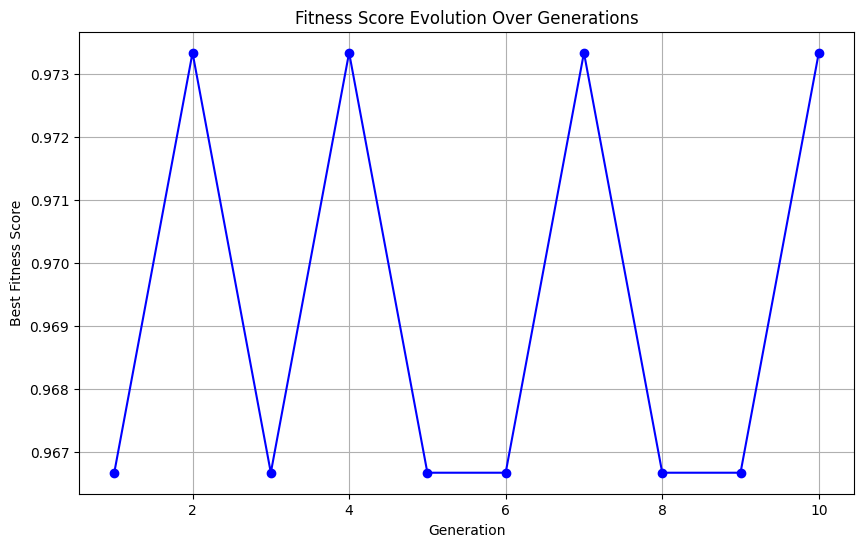

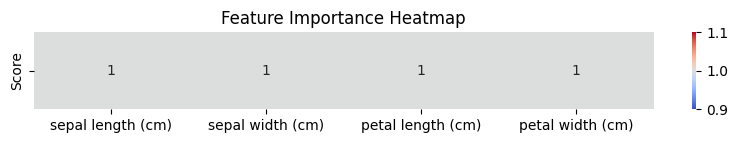

Completed processing for dataset: Iris in 5.24 seconds.
Processing dataset: WBDC (Breast Cancer Wisconsin Diagnostic)
Child1:  [0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1.] Using parent1:  [0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1]  and parent2:  [1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0]
Child2:  [1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0.]
Child1:  [1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1.] Using parent1:  [1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1]  and parent2:  [0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0]
Child2:  [0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0.]
Child1:  [1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0.] Using parent1:  [1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1

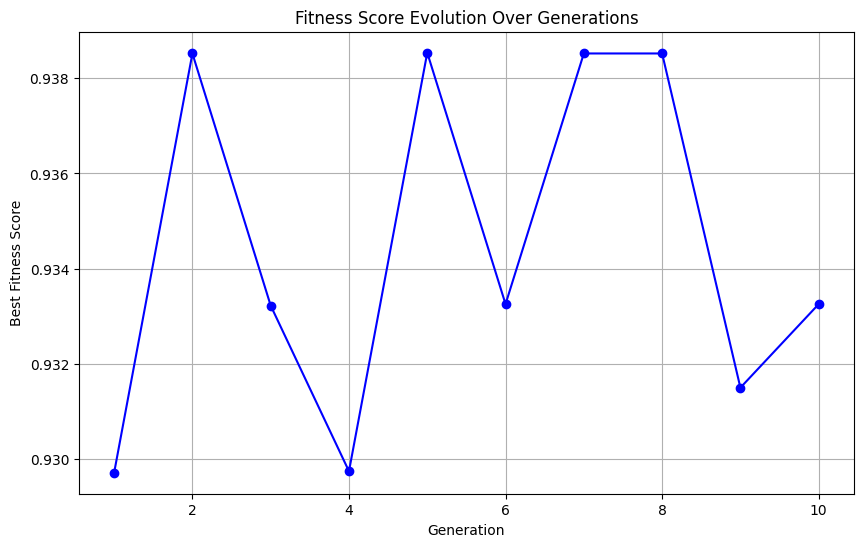

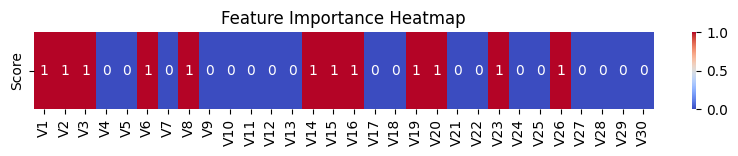

Completed processing for dataset: WBDC (Breast Cancer Wisconsin Diagnostic) in 7.88 seconds.
Processing dataset: Spambase
Child1:  [1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1.] Using parent1:  [1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1]  and parent2:  [1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0
 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1]
Child2:  [1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 1.]
Child1:  [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 1.] Using parent1:  [0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 

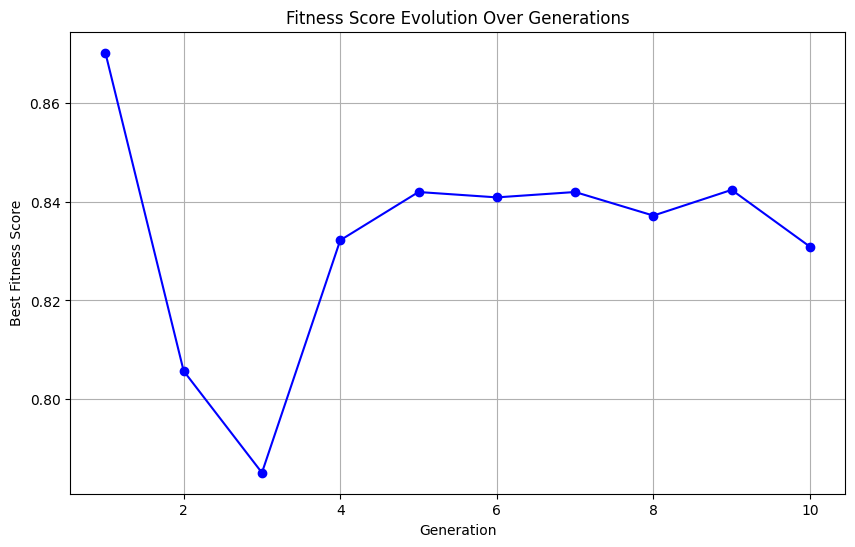

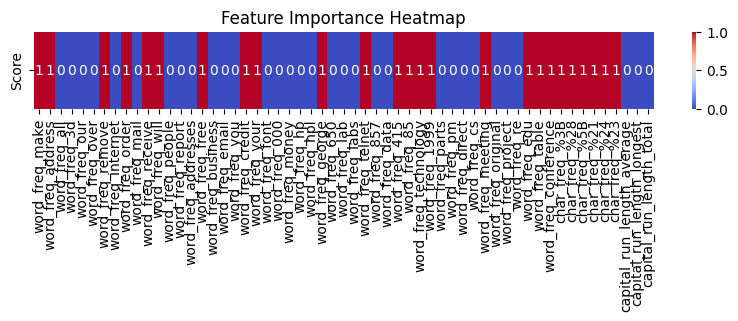

Completed processing for dataset: Spambase in 30.05 seconds.
Processing dataset: Heart


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 0. 1. 1.] Using parent1:  [1 1 1 1]  and parent2:  [1 0 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1 0 1 0]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 1. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [0 1 1 1]  and parent2:  [1 1 0 1]
Child2:  [0. 1. 0. 1.]
Child1:  [0. 1. 0. 0.] Using parent1:  [0 1 0 0]  and parent2:  [0 0 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1 1 0 0]  and parent2:  [1 0 0 1]
Child2:  [1. 1. 0. 0.]
Child1:  [1. 1. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [1 1 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 0. 1. 0.] Using parent1:  [0 0 0 0]  and parent2:  [1 0 1 0]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 1. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [1 1 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [0 1 1 1]  and parent2:  [1 1 1 1]
Child2:  [0. 1. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0 0 0 1]  and parent2:  [1 1 1 1]
Child2:  [1. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 0.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 1. 0. 0.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 0. 1. 0.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [1. 1. 0. 0.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [0. 1. 0. 1.]
Child2:  [0. 1. 0. 1.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [1. 1. 1. 0.]
Child2:  [1. 1. 0. 0.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [1. 0. 1. 0.]
Child2:  [1. 0. 1. 0.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 0. 0. 0.]
Child1:  [1. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 1. 1. 0.] Using parent1:  [0. 1. 0. 1.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [1. 0. 1. 0.]
Child2:  [0. 0. 1. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [1. 1. 0. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [1. 0. 1. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [0. 1. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 1. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 0. 0. 0.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 0. 1. 0.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [0. 1. 1. 0.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [1. 1. 1. 0.]
Child2:  [1. 0. 1. 1.]
Child1:  [0. 0. 0. 0.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [0. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [1. 0. 0. 0.] Using parent1:  [1. 0. 0. 0.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 0. 1. 1.] Using parent1:  [0. 0. 1. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 1. 1. 1.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 1. 1. 1.]
Child1:  [1. 0. 0. 0.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 1. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [0. 0. 1. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0. 1. 1. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [1. 1. 0. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [1. 1. 0. 0.]
Child2:  [1. 0. 1. 0.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [0. 0. 1. 0.]
Child2:  [0. 1. 0. 0.]
Child1:  [1. 1. 0. 0.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [1. 1. 0. 0.]
Child2:  [1. 1. 0. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [0. 0. 1. 0.]
Child2:  [1. 0. 1. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 0. 1. 0.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 0. 1.] Using parent1:  [1. 1. 0. 1.]  and parent2:  [1. 1. 0. 0.]
Child2:  [1. 1. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [1. 0. 1. 0.]
Child2:  [1. 0. 1. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 0. 1. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 0. 1. 0.]
Child1:  [0. 1. 0. 0.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [0. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [0. 0. 1. 0.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 1. 0. 1.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 0. 0. 0.] Using parent1:  [0. 1. 0. 0.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 1. 0. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 0.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 1. 0.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 0. 1. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [1. 1. 0. 1.]
Child2:  [1. 1. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 1. 1. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [0. 1. 0. 0.]
Child2:  [0. 1. 0. 0.]
Child1:  [1. 0. 1. 0.] Using parent1:  [0. 0. 0. 0.]  and parent2:  [1. 1. 1. 0.]
Child2:  [0. 1. 0. 0.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [0. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 0.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 0. 0. 0.] Using parent1:  [0. 0. 0. 0.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 0. 1.]  and parent2:  [1. 0. 1. 0.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 1. 0. 0.]
Child1:  [0. 0. 1. 0.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 1. 1. 0.] Using parent1:  [0. 1. 0. 0.]  and parent2:  [1. 1. 1. 0.]
Child2:  [0. 1. 0. 0.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 1. 1. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 1. 1. 1.] Using parent1:  [1. 1. 0. 1.]  and parent2:  [0. 0. 1. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 1. 1. 0.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 1. 0.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 1. 1. 0.] Using parent1:  [0. 1. 1. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [0. 1. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 1. 1. 0.] Using parent1:  [0. 1. 1. 0.]  and parent2:  [0. 1. 0. 1.]
Child2:  [0. 1. 0. 1.]
Child1:  [0. 1. 0. 0.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 1. 0.]
Child1:  [0. 1. 0. 0.] Using parent1:  [0. 1. 1. 0.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 0. 1. 0.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 1. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [1. 0. 1. 1.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 1.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [0. 1. 1. 1.]
Child2:  [0. 1. 0. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [0. 1. 1. 1.]
Child2:  [0. 1. 1. 0.]
Child1:  [0. 1. 1. 0.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [0. 0. 1. 0.]
Child2:  [1. 0. 1. 0.]
Child1:  [1. 1. 0. 1.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 0. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 1. 1. 0.] Using parent1:  [1. 0. 1. 0.]  and parent2:  [0. 1. 0. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 1. 1. 1.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 1. 1. 0.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 1. 1. 1.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 1.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [0. 1. 1. 1.]
Child2:  [0. 1. 1. 1.]
Child1:  [1. 1. 0. 0.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 0. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [0. 1. 0. 1.] Using parent1:  [0. 1. 1. 1.]  and parent2:  [1. 1. 0. 0.]
Child2:  [1. 1. 1. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 1. 0. 1.] Using parent1:  [0. 1. 0. 1.]  and parent2:  [1. 0. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 0. 1. 0.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 1. 0.]  and parent2:  [1. 0. 0. 0.]
Child2:  [1. 0. 0. 0.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 1. 0. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 0.]  a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


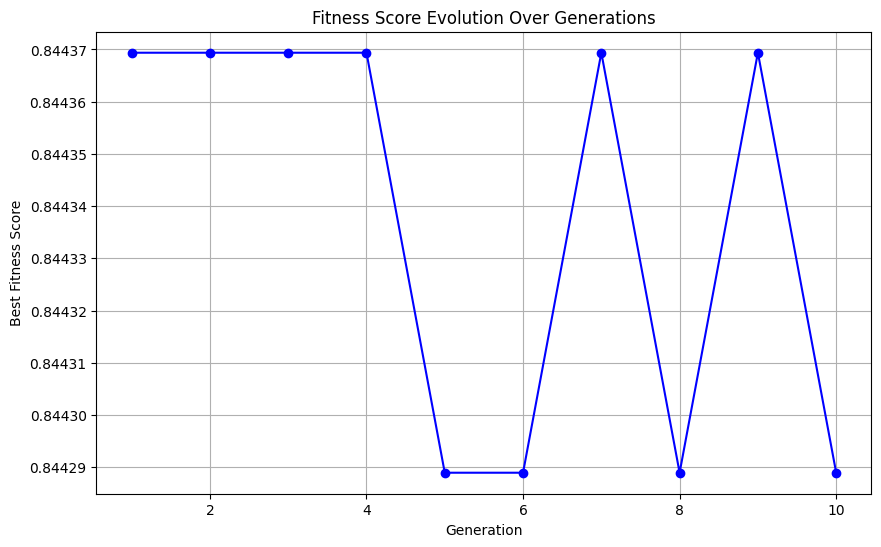

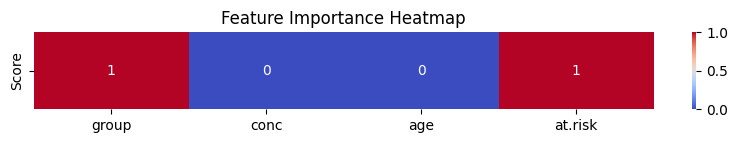

Completed processing for dataset: Heart in 11.23 seconds.
Processing dataset: Glass
Child1:  [0. 1. 1. 1. 1. 1. 1. 1. 1.] Using parent1:  [1 0 0 1 1 1 1 1 0]  and parent2:  [0 1 1 0 0 0 0 1 1]
Child2:  [1. 0. 0. 0. 0. 0. 0. 1. 0.]
Child1:  [1. 0. 0. 0. 1. 0. 1. 1. 1.] Using parent1:  [1 0 1 0 1 0 1 1 0]  and parent2:  [1 1 0 0 1 0 1 1 1]
Child2:  [1. 1. 1. 0. 1. 0. 1. 1. 0.]
Child1:  [1. 1. 1. 1. 1. 0. 1. 1. 1.] Using parent1:  [1 1 1 1 0 0 1 0 0]  and parent2:  [1 1 0 0 1 0 1 1 1]
Child2:  [1. 1. 0. 0. 0. 0. 1. 0. 0.]
Child1:  [0. 0. 1. 0. 0. 0. 1. 1. 1.] Using parent1:  [1 1 1 1 0 0 1 0 0]  and parent2:  [0 0 0 0 0 1 0 1 1]
Child2:  [1. 1. 0. 1. 0. 1. 0. 0. 0.]
Child1:  [0. 0. 1. 0. 0. 0. 1. 1. 0.] Using parent1:  [1 0 1 0 0 0 0 1 0]  and parent2:  [0 0 0 1 0 0 1 1 0]
Child2:  [1. 0. 0. 1. 0. 0. 0. 1. 0.]
Child1:  [0. 1. 1. 0. 1. 0. 1. 1. 1.] Using parent1:  [0 0 1 0 1 0 0 1 1]  and parent2:  [0 1 0 0 0 0 1 1 0]
Child2:  [0. 0. 0. 0. 0. 0. 0. 1. 0.]
Child1:  [1. 0. 1. 1. 0. 1. 1. 0. 

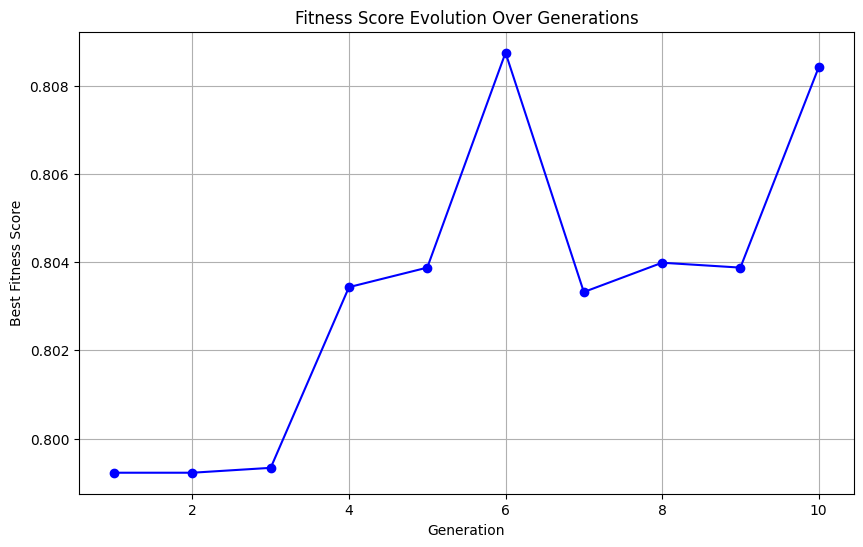

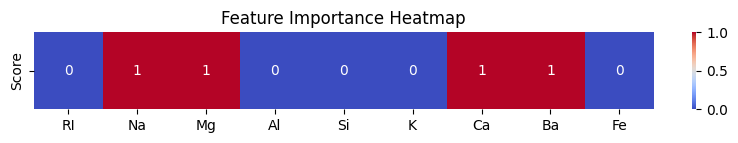

Completed processing for dataset: Glass in 7.48 seconds.
Processing dataset: WBC (Breast Cancer Wisconsin Original)
Child1:  [1. 0. 1. 0. 1. 1. 1. 1. 1.] Using parent1:  [0 0 1 0 1 0 1 0 1]  and parent2:  [1 0 1 1 1 1 1 1 0]
Child2:  [0. 0. 1. 1. 1. 0. 1. 0. 0.]
Child1:  [1. 1. 0. 1. 0. 1. 1. 0. 1.] Using parent1:  [0 0 1 1 0 1 1 1 1]  and parent2:  [1 1 0 1 0 1 1 0 1]
Child2:  [0. 0. 1. 1. 0. 1. 1. 1. 1.]
Child1:  [0. 0. 1. 1. 1. 1. 0. 1. 0.] Using parent1:  [0 1 1 1 1 1 0 0 0]  and parent2:  [0 0 1 1 0 1 1 1 1]
Child2:  [0. 1. 1. 1. 0. 1. 1. 0. 1.]
Child1:  [0. 1. 0. 1. 0. 1. 1. 1. 1.] Using parent1:  [0 1 0 0 0 1 1 1 0]  and parent2:  [1 1 0 1 0 1 1 0 1]
Child2:  [1. 1. 0. 0. 0. 1. 1. 0. 0.]
Child1:  [0. 0. 1. 1. 0. 1. 0. 1. 0.] Using parent1:  [1 0 1 1 1 0 0 1 0]  and parent2:  [0 0 0 0 0 1 0 0 1]
Child2:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Child1:  [0. 0. 1. 0. 1. 1. 0. 0. 0.] Using parent1:  [0 0 1 0 0 0 0 1 0]  and parent2:  [0 1 1 1 1 1 0 0 0]
Child2:  [0. 1. 1. 1. 0. 0. 0. 1. 0.]
Ch

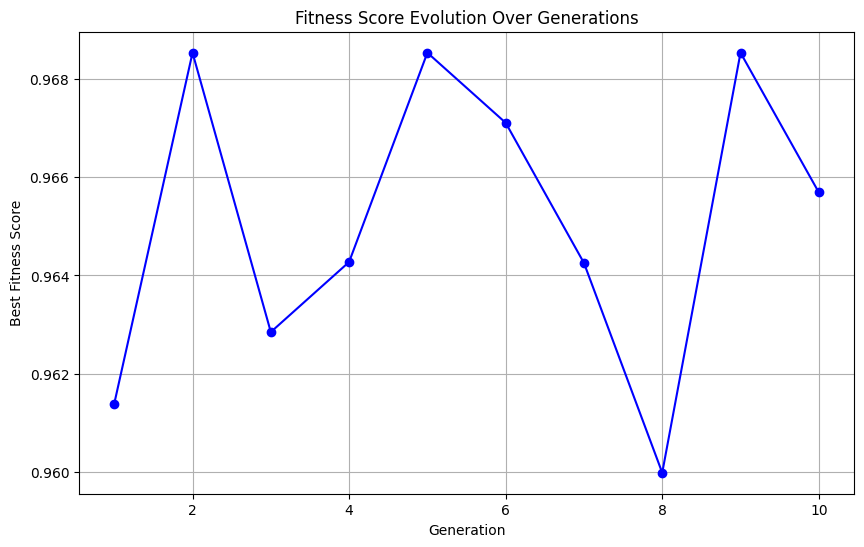

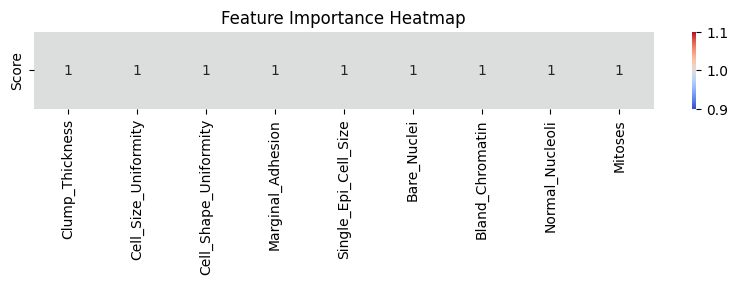

Completed processing for dataset: WBC (Breast Cancer Wisconsin Original) in 13.00 seconds.
Processing dataset: Ionosphere
Child1:  [0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.] Using parent1:  [0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0]  and parent2:  [0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0]
Child2:  [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Child1:  [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.] Using parent1:  [1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0]  and parent2:  [1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1]
Child2:  [1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
Child1:  [0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1

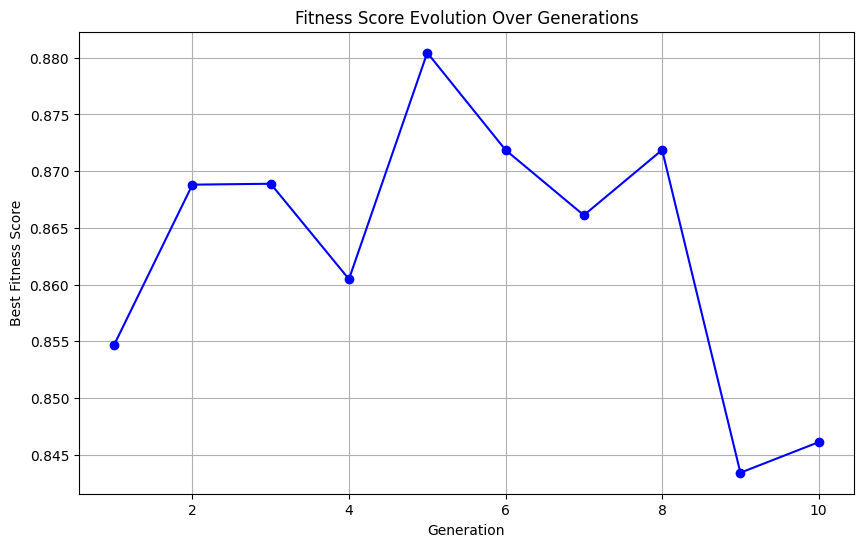

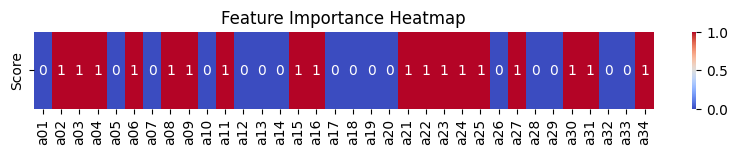

Completed processing for dataset: Ionosphere in 5.35 seconds.
Processing dataset: Arrhythmia


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.] Using parent1:  [0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1
 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.] Using parent1:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.] Using parent1:  [1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1.] Using parent1:  [0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.] Using parent1:  [1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.] Using parent1:  [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.] Using parent1:  [1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.] Using parent1:  [1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.] Using parent1:  [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] Using parent1:  [1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


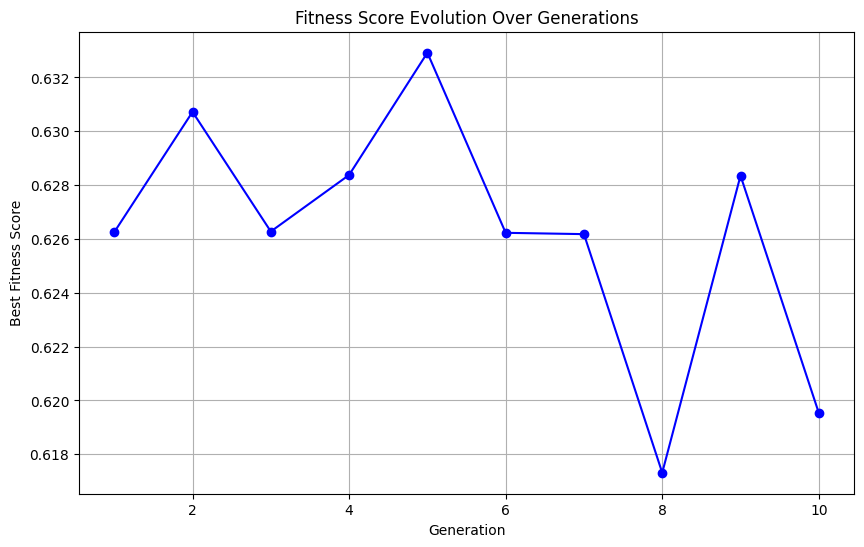

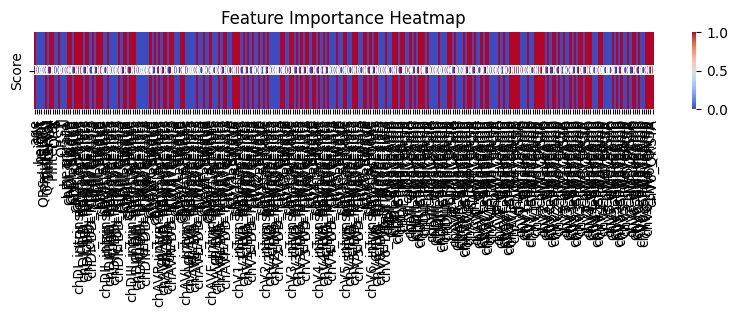

Completed processing for dataset: Arrhythmia in 6.68 seconds.
Processing dataset: Multiple Features
Child1:  [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.] Using parent1:  [0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0
 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 

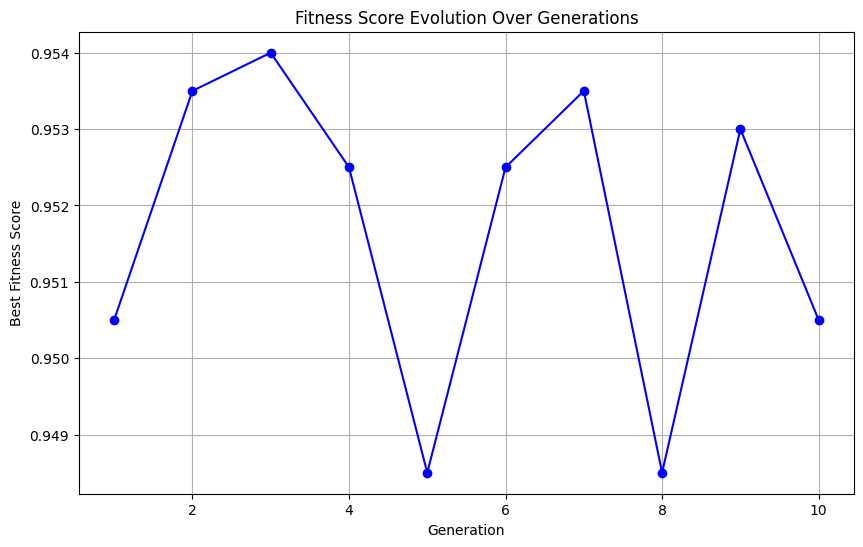

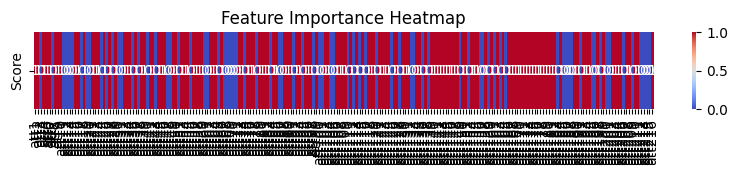

Completed processing for dataset: Multiple Features in 14.54 seconds.
Processing dataset: Australian
Child1:  [1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.] Using parent1:  [0 1 1 1 1 1 1 1 0 0 1 1 0 0]  and parent2:  [1 0 1 0 1 0 1 1 0 1 1 0 0 1]
Child2:  [0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
Child1:  [1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.] Using parent1:  [1 0 1 1 1 0 1 1 1 0 1 1 1 1]  and parent2:  [1 0 1 1 0 0 0 1 0 1 0 1 0 1]
Child2:  [1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
Child1:  [1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.] Using parent1:  [1 1 0 1 0 0 1 0 1 0 1 1 0 1]  and parent2:  [1 0 1 1 1 0 1 1 1 0 1 1 1 1]
Child2:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
Child1:  [1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.] Using parent1:  [1 1 1 0 1 0 1 0 1 0 0 0 1 1]  and parent2:  [1 0 0 0 1 0 1 1 1 0 0 0 0 0]
Child2:  [1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
Child1:  [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] Using parent1:  [0 1 0 0 0 0 0 0 1 0 0 0 0 0]  and parent2

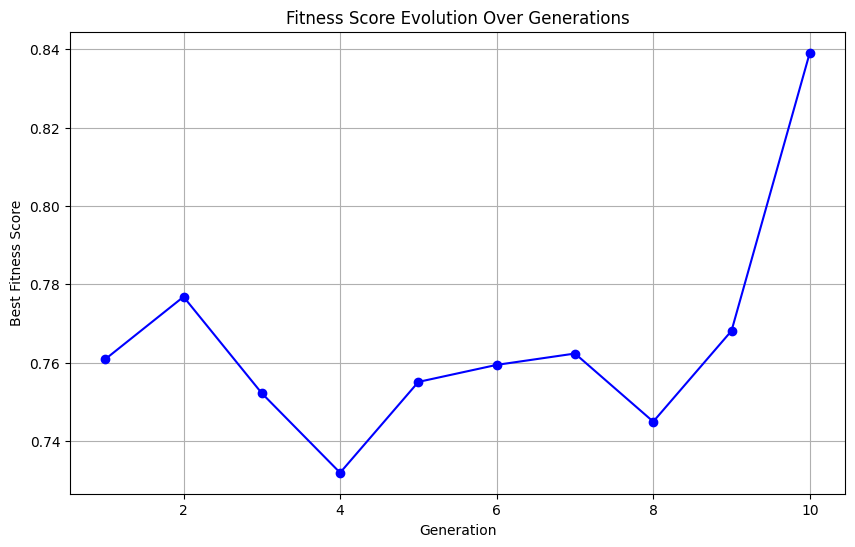

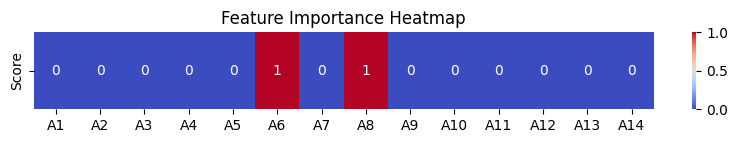

Completed processing for dataset: Australian in 12.92 seconds.
Processing dataset: DNA
Child1:  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.] Using parent1:  [0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1
 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1
 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0
 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 

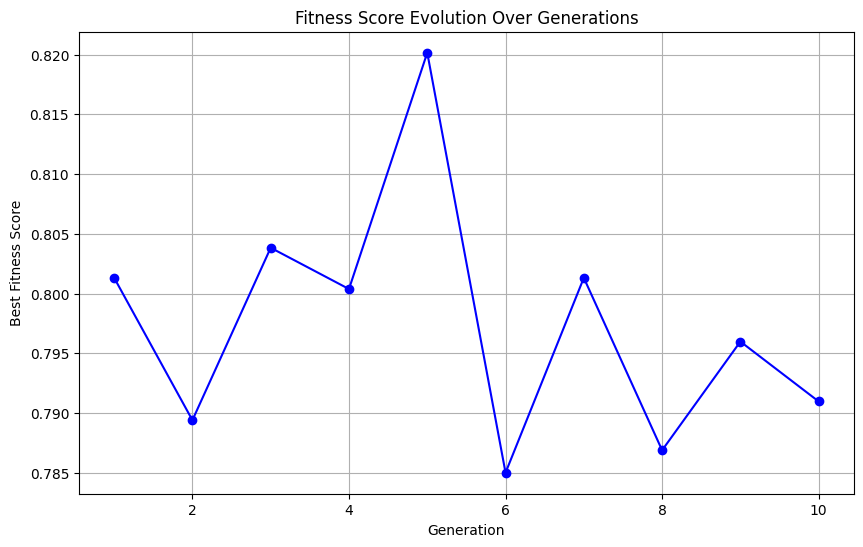

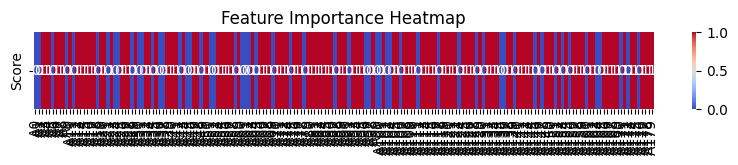

Completed processing for dataset: DNA in 25.51 seconds.
Processing dataset: Wine
Child1:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] Using parent1:  [0 0 1 1 1 1 1 0 1 0 1 1 0]  and parent2:  [0 1 1 1 1 1 1 1 1 1 1 1 1]
Child2:  [0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0.]
Child1:  [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.] Using parent1:  [0 1 0 1 0 1 1 1 1 1 1 0 0]  and parent2:  [0 1 0 1 0 1 1 1 1 1 1 0 0]
Child2:  [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
Child1:  [0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.] Using parent1:  [0 1 1 1 1 1 1 1 0 1 0 1 0]  and parent2:  [0 1 0 1 0 1 1 1 1 1 1 0 0]
Child2:  [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
Child1:  [1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.] Using parent1:  [0 1 1 0 0 1 1 1 0 1 0 0 0]  and parent2:  [1 0 0 1 1 0 0 0 1 0 0 1 0]
Child2:  [0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]
Child1:  [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.] Using parent1:  [1 0 0 1 1 0 0 0 1 0 0 1 0]  and parent2:  [0 0 0 0 0 1 0 0 1 0 1 0 1]
Child2:  [0. 0. 0. 1. 0. 1. 0. 0. 

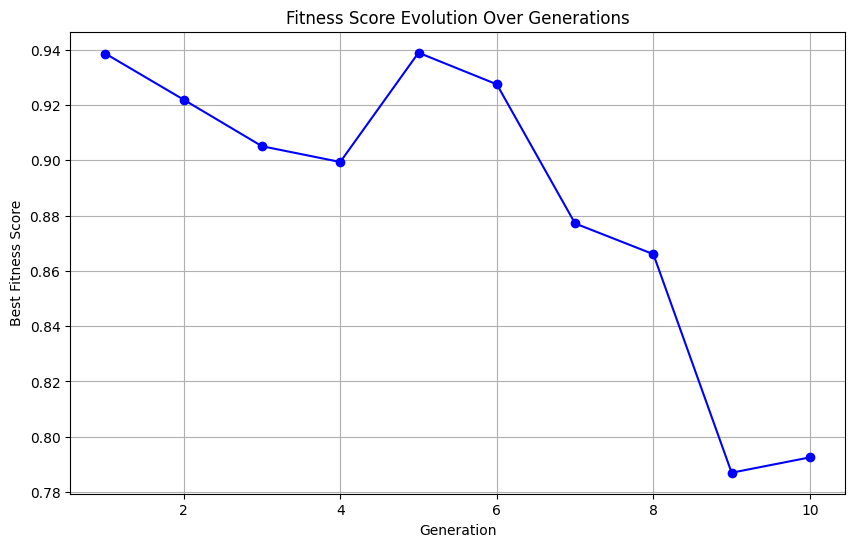

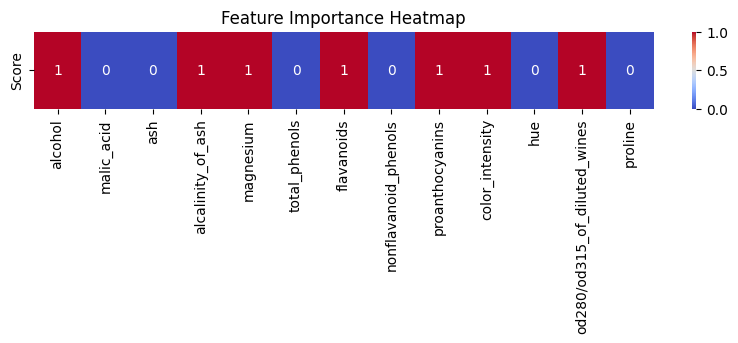

Completed processing for dataset: Wine in 6.97 seconds.
Processing dataset: Vehicle
Child1:  [1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.] Using parent1:  [1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]  and parent2:  [0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0]
Child2:  [0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.]
Child1:  [0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.] Using parent1:  [0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0]  and parent2:  [0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1]
Child2:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
Child1:  [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.] Using parent1:  [1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0]  and parent2:  [0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1]
Child2:  [0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.]
Child1:  [0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.] Using parent1:  [0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0]  and parent2:  [0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1]
Child2:  [0. 1. 1. 0. 1. 0. 0. 1.

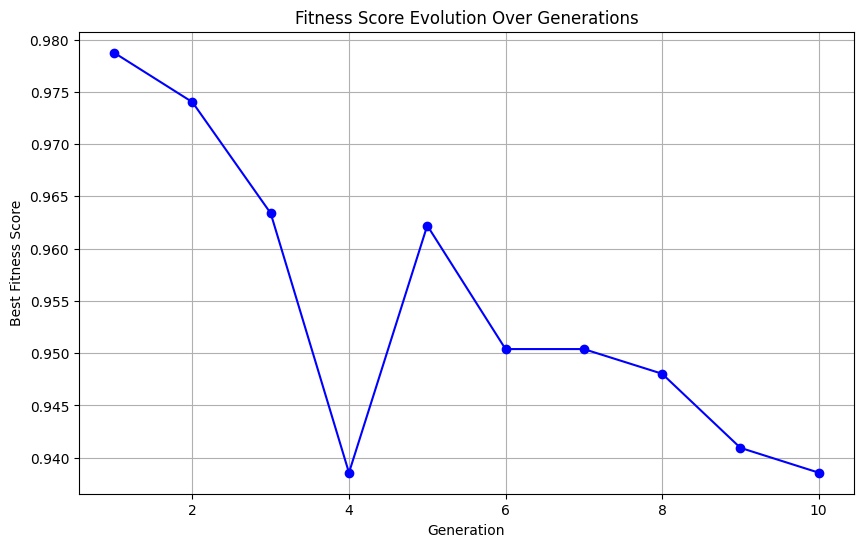

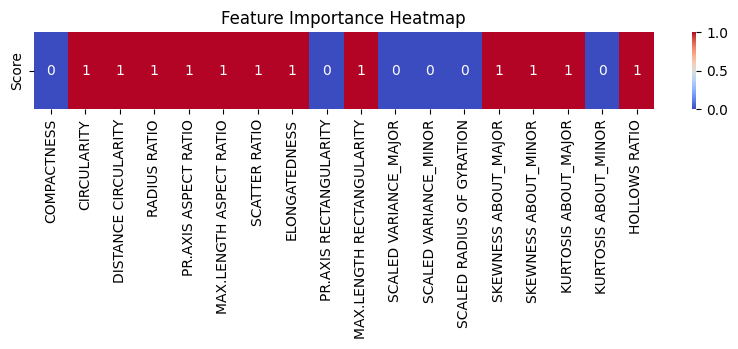

Completed processing for dataset: Vehicle in 15.22 seconds.
Processing dataset: Waveform
Child1:  [1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.] Using parent1:  [1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1
 1 0 0]  and parent2:  [0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0
 1 0 1]
Child2:  [0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
Child1:  [0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.] Using parent1:  [0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 1 0]  and parent2:  [0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1
 1 1 0]
Child2:  [0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.

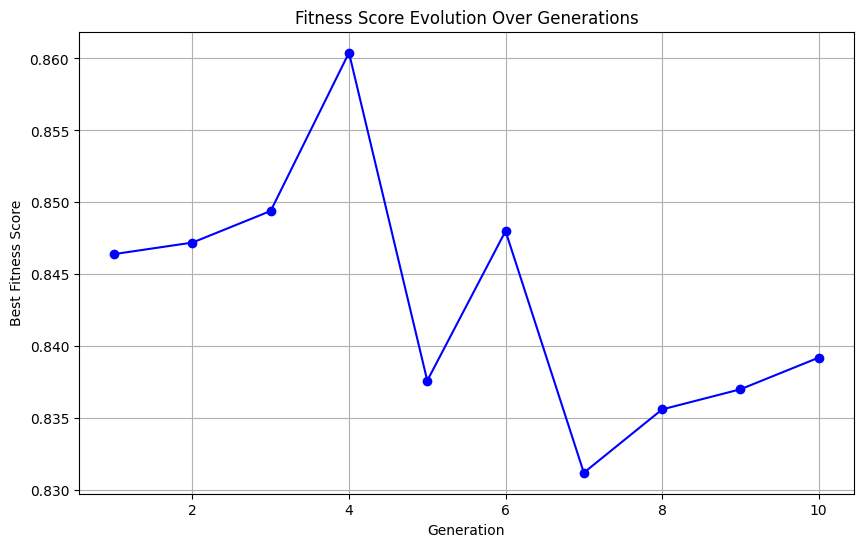

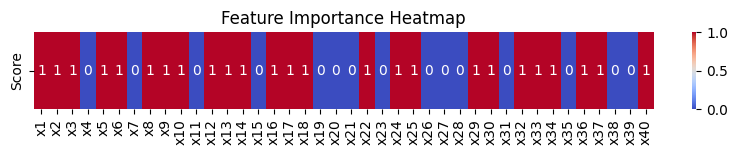

Completed processing for dataset: Waveform in 77.60 seconds.
Processing dataset: Zoo
Error processing dataset Zoo: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'true'
Processing dataset: Hillvalley
Child1:  [1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 1.] Using parent1:  [1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1
 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1]  and parent2:  [1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0]
Child2:  [

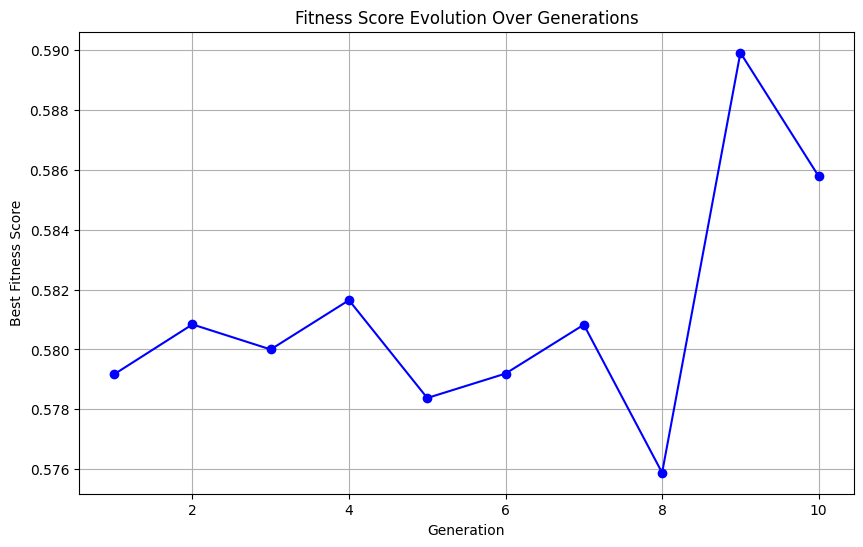

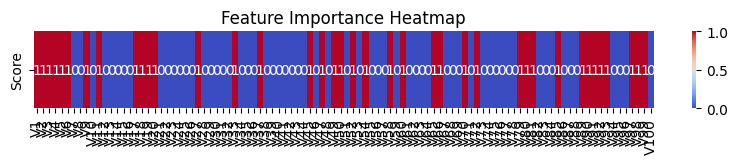

Completed processing for dataset: Hillvalley in 5.79 seconds.
Processing dataset: Sonar
Child1:  [1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.] Using parent1:  [1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0
 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0]  and parent2:  [0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0
 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0]
Child2:  [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
Child1:  [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.] Using parent1:  [0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1

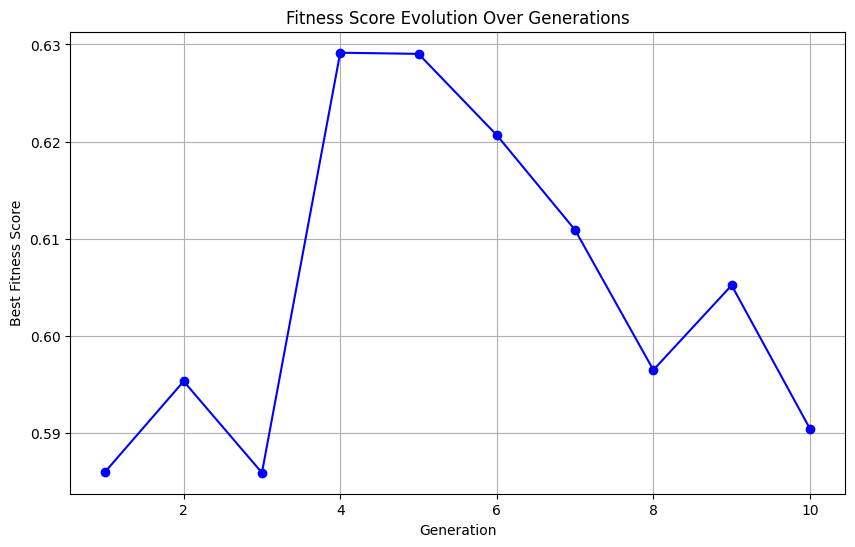

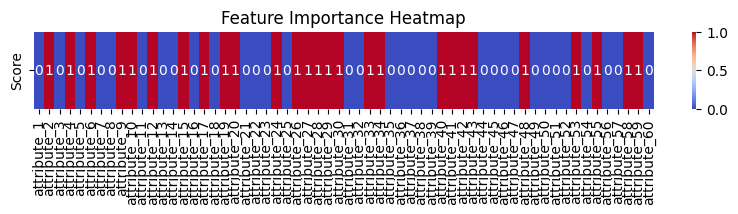

Completed processing for dataset: Sonar in 3.84 seconds.


In [8]:

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
cv = StratifiedKFold(n_splits=5)
estimator = KNeighborsClassifier()
# Main loop with preprocessing
for dataset_name, loader in datasets:
    output_dir = os.path.join("./output_results", dataset_name)
    os.makedirs(output_dir, exist_ok=True)
    print(f"Processing dataset: {dataset_name}")
    generation_times = []
    individual_times = []

    try:
        # Load dataset
        data = loader()
        if isinstance(data, tuple):  # Handle sklearn's load_iris/load_wine
            X, y = data
            feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
        else:  # Handle OpenML datasets
            X, y = data.data, data.target
            feature_names = data.feature_names if hasattr(data, 'feature_names') else [f"Feature_{i}" for i in range(X.shape[1])]



        # Initialize SAGAFS_GA
        saga_fs = SAGAFS_GA(
            estimator=estimator,
            cv=cv,
            scoring='accuracy',
            population_size=20,  # Adjust as needed
            generations=10,  # Adjust as needed
            mutation_rate=0.1,  # Adjust as needed
            crossover_rate=0.5,  # Adjust as needed
            param_grid=param_grid
        )

         # Preprocess the dataset
        X, y = saga_fs.preprocess_dataset(X, y)

        # Measure time for generation evolution
        start_time = time.time()
        saga_fs.fit(X, y, dataset_name=dataset_name, output_dir=output_dir)
        total_time = time.time() - start_time

        # Plot fitness over generations
        saga_fs.plot_fitness_over_generations()

        # Optional: Plot heatmap if feature names and scores are available
        if hasattr(saga_fs, 'best_individual') and saga_fs.best_individual is not None:
            feature_scores = saga_fs.best_individual
            saga_fs.plot_heatmap(feature_scores, feature_names)

        print(f"Completed processing for dataset: {dataset_name} in {total_time:.2f} seconds.")

    except Exception as e:
        print(f"Error processing dataset {dataset_name}: {e}")

Child1:  [1. 0. 0. 1.] Using parent1:  [1 0 0 1]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 1. 0. 0.] Using parent1:  [0 1 0 0]  and parent2:  [0 0 0 0]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [0 1 1 1]  and parent2:  [1 0 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0 1 0 0]  and parent2:  [0 1 1 1]
Child2:  [0. 1. 0. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1 1 1 1]  and parent2:  [0 0 0 0]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 1. 0. 1.] Using parent1:  [0 1 0 0]  and parent2:  [0 1 1 1]
Child2:  [0. 1. 1. 0.]
Child1:  [0. 1. 0. 1.] Using parent1:  [0 1 0 0]  and parent2:  [0 0 1 1]
Child2:  [0. 0. 1. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1 0 1 1]  and parent2:  [1 0 1 1]
Child2:  [1. 0. 1. 1.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1 1 0 0]  and parent2:  [1 0 1 1]
Child2:  [1. 1. 0. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1 0 1 0]  and parent2:  [0 1 0 1]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 1. 1. 0.] Using p

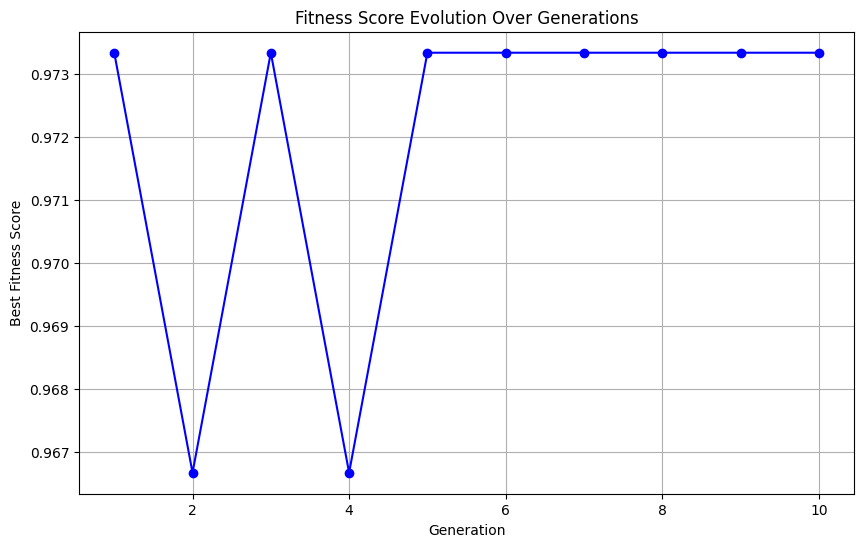

Best Parameters: [1. 1. 1. 1.]
Best Features Selected: [0 1 2 3]


In [27]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Define parameters
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
cv = StratifiedKFold(n_splits=5)
estimator = KNeighborsClassifier()

# Initialize and fit SAGAFS_GA
ga = SAGAFS_GA(
    estimator=estimator,
    cv=cv,
    scoring='accuracy',
    population_size=20,
    generations=10,
    mutation_rate=0.1,
    crossover_rate=0.5,
    param_grid=param_grid
)
ga.fit(X, y, dataset_name="iris", output_dir="results")

# Plot results
ga.plot_fitness_over_generations()

# Print the best parameters and features
print("Best Parameters:", ga.best_individual)
print("Best Features Selected:", np.where(ga.best_individual == 1)[0])
